### Importação de Biblioteca

In [1]:
import os, random
random.seed(2)
import numpy as np
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromFile

import tensorflow as tf
from sklearn.utils import resample
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


import math

from IPython.core.display import HTML
from pretty_confusion_matrix import pp_matrix_from_data

### Modificando design do jupyter Notebook

In [2]:
def jupyter_settings():
    display(HTML('<style>.container {width:100% !important;}</style>'))
jupyter_settings()

# ------------------------------------------------
# --------(Criando Chips de Imagem)--------
# ------------------------------------------------

### Váriaveis - Criando Chips de Imagem

In [13]:
chipSize = 19
featuresName = 'CNN_' + str(chipSize) + 'by' + str(chipSize) + '_features.npy'
labelsName = 'CNN_' + str(chipSize) + 'by' + str(chipSize) + '_labels.npy'

### Change the working directory

In [14]:
output_directory = r"/Users/luizramos/Repos/CNN - Deep Learning sensoreamento remoto/Data"
os.chdir(output_directory)

### define the file names

In [15]:
feature_file = r"ImagemVIG.tif"
label_file = r"ImagemRotulada_qgis.tif"

### create feature chips using pyrsgis

In [16]:
features = imageChipsFromFile(feature_file, x_size=chipSize, y_size=chipSize)
print(feature_file)
features = np.rollaxis(features, 3, 1)

ImagemVIG.tif


### read the label file and reshape it

In [18]:
ds, labels = raster.read(label_file)
labels = labels.flatten()

### print basic details

In [19]:
print('Input features shape:', features.shape)
print('\nInput labels shape:', labels.shape)
print('Values in input features, min: %d & max: %d' % (features.min(), features.max()))
print('Values in input labels, min: %d & max: %d' % (labels.min(), labels.max()))

Input features shape: (3554838, 4, 19, 19)

Input labels shape: (3554838,)
Values in input features, min: 0 & max: 255
Values in input labels, min: 0 & max: 1


### Save the arrays as .npy files

In [20]:
np.save(featuresName, features)
np.save(labelsName, labels)

# ------------------------------------------------
# -------------(Treinando Modelo)------------
# ------------------------------------------------

### Variáveis - Treinando Modelo

In [35]:
chipSize = 19
epochsNumber = 100
batchsize = 512
#samples = 20000
featuresName = 'CNN_' + str(chipSize) + 'by' + str(chipSize) + '_features.npy'
labelsName = 'CNN_' + str(chipSize) + 'by' + str(chipSize) + '_labels.npy'
trainedModelDir = '1_trained_models_' + str(chipSize) + 'by' + str(chipSize) + '_' + str(epochsNumber) + 'Epochs' + '_' + str(batchsize) + 'batchsize'
modelFile = trainedModelDir + '/200409_CNN_Builtup_' + str(chipSize)+ 'by' + str(chipSize) +'_' + str(epochsNumber) + 'Epochs_PScore%.3f_RScore%.3f_FScore%.3f.h5'


### Change the working directory

In [36]:
output_directory = r"/Users/luizramos/Repos/CNN - Deep Learning sensoreamento remoto/Data"
os.chdir(output_directory)

### Load arrays from .npy files

In [5]:
features = np.load(featuresName)
labels = np.load(labelsName)

### Separate and balance the classes

In [6]:
built_features = features[labels==1]
built_labels = labels[labels==1]

unbuilt_features = features[labels==0][:int(built_labels.shape[0])]
unbuilt_labels = labels[labels==0][:int(built_labels.shape[0])]

print('Number of records in each class:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

Number of records in each class:
Built: 354680, Unbuilt: 354680


### Downsample the majority class

In [7]:
unbuilt_features = resample(unbuilt_features,
                            replace = False, # sample without replacement
                            n_samples = built_features.shape[0], # match minority n
                            random_state = 2)

unbuilt_labels = resample(unbuilt_labels,
                          replace = False, # sample without replacement
                          n_samples = built_features.shape[0], # match minority n
                          random_state = 2)

print('Number of records in balanced classes:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

Number of records in balanced classes:
Built: 354680, Unbuilt: 354680


### Combine the balanced features

In [8]:
features = np.concatenate((built_features, unbuilt_features), axis=0)
labels = np.concatenate((built_labels, unbuilt_labels), axis=0)

### Normalise the features

In [9]:
features = features / 255.0
print('New values in input features, min: %d & max: %d' % (features.min(), features.max()))

New values in input features, min: 0 & max: 1


### Define the function to split features and labels

In [11]:
def train_test_split(features, labels, trainProp=0.6):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    train_y = labels[randIndex[:sliceIndex]]
    test_y = labels[randIndex[sliceIndex:]]
    return(train_x, train_y, test_x, test_y)

### Call the function to split the data

In [12]:
train_x, train_y, test_x, test_y = train_test_split(features, labels)

### Transpose the features to channel last format

In [13]:
train_x = tf.transpose(train_x, [0, 2, 3, 1])
test_x = tf.transpose(test_x, [0, 2, 3, 1])
print('Reshaped features:', train_x.shape, test_x.shape)
_, rowSize, colSize, nBands = train_x.shape


Metal device set to: Apple M1 Pro


2022-07-11 09:50:48.347069: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-11 09:50:48.347482: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Reshaped features: (425616, 19, 19, 4) (283744, 19, 19, 4)


204267

### Create a model

In [37]:
model = keras.Sequential()
model.add(Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(chipSize, chipSize, nBands)))
model.add(Dropout(0.25))
model.add(Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

### Run the model

In [38]:
with tf.device('/cpu:0'):
    model.compile(loss='sparse_categorical_crossentropy', optimizer= 'adam',metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=epochsNumber, validation_split = 0.15, use_multiprocessing = False, batch_size=batchsize)

Epoch 1/100


2022-07-11 10:30:45.652422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


707/707 [==============================] - ETA: 0s - loss: 0.6504 - accuracy: 0.5490

2022-07-11 10:31:55.794167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


707/707 [==============================] - 73s 103ms/step - loss: 0.6504 - accuracy: 0.5490 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 2/100
707/707 [==============================] - 73s 103ms/step - loss: 0.6372 - accuracy: 0.5555 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 3/100
707/707 [==============================] - 73s 103ms/step - loss: 0.6344 - accuracy: 0.5555 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 4/100
707/707 [==============================] - 73s 103ms/step - loss: 0.6321 - accuracy: 0.5568 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 5/100
707/707 [==============================] - 72s 102ms/step - loss: 0.6306 - accuracy: 0.5560 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 6/100
707/707 [==============================] - 72s 102ms/step - loss: 0.6290 - accuracy: 0.5583 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 7/100
707/707 [==============================] - 72s 102ms/step - loss: 0.6282 - accuracy: 0.5578 - val_loss: 0.6931 - val_accurac

Epoch 57/100
707/707 [==============================] - 72s 102ms/step - loss: 0.6125 - accuracy: 0.5631 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 58/100
707/707 [==============================] - 72s 102ms/step - loss: 0.6126 - accuracy: 0.5641 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 59/100
707/707 [==============================] - 74s 105ms/step - loss: 0.6124 - accuracy: 0.5634 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 60/100
707/707 [==============================] - 74s 104ms/step - loss: 0.6122 - accuracy: 0.5639 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 61/100
707/707 [==============================] - 74s 105ms/step - loss: 0.6120 - accuracy: 0.5643 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 62/100
707/707 [==============================] - 74s 105ms/step - loss: 0.6123 - accuracy: 0.5644 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 63/100
707/707 [==============================] - 74s 105ms/step - loss: 0.6124 - accuracy: 0.5635 - val_loss: 0

### Plotando Acuracia Treino e Validação

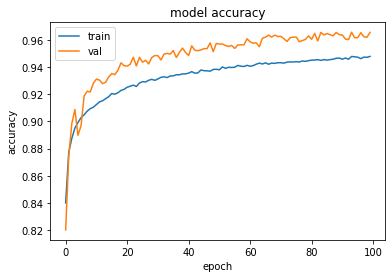

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Plotando o Loss - Treino e Validação

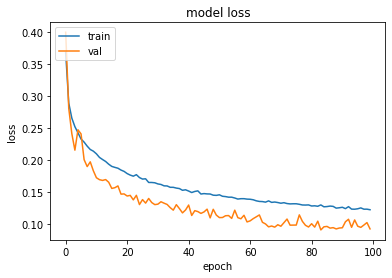

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Predict for test data 

In [21]:
with tf.device('/gpu:0'):
    yTestPredicted = model.predict(test_x)
    yTestPredicted = yTestPredicted[:,1]

2022-07-05 00:05:12.677654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12767/12767 [==============================] - 47s 4ms/step


### Calculate and display the error metrics

In [22]:
yTestPredicted = (yTestPredicted>0.6).astype(int)
cMatrix = confusion_matrix(test_y, yTestPredicted)
pScore = precision_score(test_y, yTestPredicted)
rScore = recall_score(test_y, yTestPredicted)
fScore = f1_score(test_y, yTestPredicted)

print("Confusion matrix:\n", cMatrix)

print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fScore))

Confusion matrix:
 [[244975    395]
 [149333  13833]]

P-Score: 0.972, R-Score: 0.085, F-Score: 0.156


### contar Matriz e medir tempo de execucao

In [24]:
import time

start_time = time.time()

i = 0
coqueiro = 0
ncoqueiro = 0

for i in range(len(test_y)):
    if test_y[i] == 1:
        coqueiro = coqueiro + 1 
    else:
        ncoqueiro = ncoqueiro + 1

print(f'Coqueiro: {coqueiro} | Nao-Coqueiro: {ncoqueiro}')

end_time = time.time()

print(f'O tempo de execucao foi: {end_time-start_time}')
        
    

Coqueiro: 163166 | Nao-Coqueiro: 245370
O tempo de execucao foi: 0.3521561622619629


### Matriz confusão

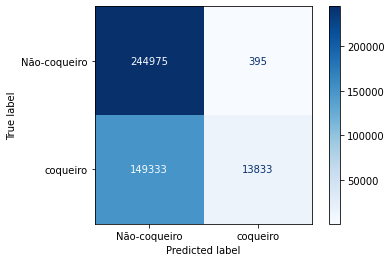

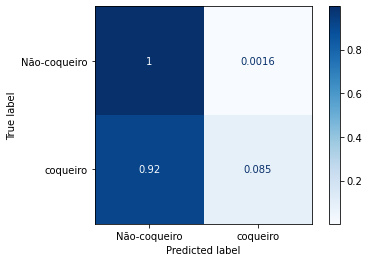

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cMatrix, display_labels=['Não-coqueiro', 'coqueiro'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

cMatrixNormalized = cMatrix.astype('float') / cMatrix.sum(axis=1)[:, np.newaxis]
disp2 = ConfusionMatrixDisplay(confusion_matrix=cMatrixNormalized, display_labels=['Não-coqueiro', 'coqueiro'])
disp2.plot(cmap=plt.cm.Blues)
plt.show()

### Save the model to use later

In [27]:

if not os.path.exists(os.path.join(os.getcwd(), trainedModelDir)):
    os.mkdir(os.path.join(os.getcwd(), trainedModelDir))

model.save(modelFile % (pScore, rScore, fScore)) 

# ------------------------------------------------
# ---------(Predizendo novos dados)---------
# ------------------------------------------------

### Variáveis - Predizendo novos dados

In [28]:
chipSize = 19
new_features_dtype = 'float32'
epochsNumber = 100
trainedModelDir = '_trained_models_' + str(chipSize) + 'by' + str(chipSize) + '_' + str(epochsNumber) + 'Epochs'
outFile = '2_ImagemVIG_predicted_' + str(chipSize) + 'x' + str(chipSize) + '_' + str(epochsNumber) + 'Epochs_' + new_features_dtype + '.tif'


### Load the saved model

In [29]:
model = tf.keras.models.load_model('/Users/luizramos/Repos/CNN - Deep Learning sensoreamento remoto/Data/2_trained_models_19by19_100Epochs_256batchsize/200409_CNN_Builtup_19by19_100Epochs_PScore0.972_RScore0.085_FScore0.156.h5')

### Load a new multispectral image

In [30]:
ds, featuresHyderabad = raster.read('/Users/luizramos/Repos/CNN - Deep Learning sensoreamento remoto/Data/ImagemVIG.tif')

### Generate image chips in the back-end

In [31]:
def CNNdataGenerator(mxBands, kSize):
    mxBands = mxBands / 255.0
    nBands, rows, cols = mxBands.shape
    margin = math.floor(kSize/2)
    mxBands = np.pad(mxBands, margin, mode='constant')[margin:-margin, :, :]

    features = np.empty((rows*cols, kSize, kSize, nBands), dtype=new_features_dtype)

    n = 0
    for row in range(margin, rows+margin):
        for col in range(margin, cols+margin):
            feat = mxBands[:, row-margin:row+margin+1, col-margin:col+margin+1]

            b1, b2, b3, b4 = feat
            feat = np.dstack((b1, b2, b3, b4))

            features[n, :, :, :] = feat
            n += 1
            
    return(features)

### Call the function to generate features tensor

In [32]:
new_features = CNNdataGenerator(featuresHyderabad, kSize=chipSize)
print('Shape of the new features', new_features.shape)

Shape of the new features (3554838, 19, 19, 4)


### Predict new data and export the probability raster

In [33]:
print(outFile)

2_ImagemVIG_predicted_19x19_100Epochs_float32.tif


In [34]:
with tf.device('/cpu:0'):
    newPredicted = model.predict(new_features)
    newPredicted = newPredicted[:,1]
    prediction = np.reshape(newPredicted, (ds.RasterYSize, ds.RasterXSize))
    raster.export(prediction, ds, filename=outFile, dtype=str(new_features.dtype))

    37/111089 [..............................] - ETA: 7:52

2022-07-05 00:08:30.812551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111089/111089 [==============================] - 452s 4ms/step
